# Построение модели предсказания коэффициента восстановления золота из руды

Моя задача состоит в том, чтобы на основе данных с параметрами добычи и очистки золота создать модель, которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды. 

Для удобства определю предварительную декомпозицию задачи:
1. Изучу данные и проведу анализ признаков.

Импортирую библиотеки,настрою опции ячеек, затем изучу признаки в датафрейме, проверю часть формул, и определю, какую часть данных нужно удалить для корректной работы модели.
    
2. Проведу предобработку данных.

Проверю датафреймы на наличие пропусков, дубликатов, неподходящих типов файлов. Решу, как избавиться от пропусков.

3. Исследую конкретные данные: концентрацию, распределния размеров гранул и тд.

В датафреймах представлены специфичные данные в области золотодобывающей промышленности. Моей задачей будет исследовать характеристики сырья и продукта на этапах очистки, сравнить их и проанализировать результаты вычислений.
    
4. Составлю функцию для вычисления главной метрики - sMAPE.

Специфичным данным - специфичная метрика. Модель предсказания коэффициент восстановления золота из золотосодержащей руды будет оцениваться на основе метрики sMAPE (Symmetric Mean Absolute Percentage Error). На основе представленной в условии формулы составлю формулу для расчета в Phyton, проверю, какая наименьшая средняя ошибка будет у моделей
    
5. Построю модели, проведу кросс-валидацию.

Формуле я буду передавать предсказания модели, ошибка будет зависеть в том числе от подобранных гиперпараметров, правильности подготовки выборок. Для большей уверенности будет использоваться кросс-валидация.
    
6. Проверка на тестовой выборке.

Оценив модель и выбрав наилушчий вариант по sMAPE перейду к предсказанию на тестовой выборке, она содержится изначально в отдельном датафрейме.
    
7. Выводы

Получив результат на тестовой выборке подведу итог исследования и создания модели, рассмотрю приемлемость использования модели для повышения эффективности работы золотодобывающих предприятий.

## Подготовка данных

### Импорт инструментов, обзор данных

Импортирую библиотеки, открою файлы, изучу данные

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn.metrics import fbeta_score, make_scorer, mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.utils import shuffle

In [ ]:
pd.set_option('display.max_columns', 87)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

In [ ]:
data_test.info()
data_train.info()
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
data_test

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [ ]:
data_train 

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [ ]:
data_full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

В трех датафреймах представлены данные, которые уже поделены на тренировочную и тестовую выборки. Очень много данных, в датафрейме train нет части строк, в test - части столбцов.

### Эффективность обогащения

Перед тем как изучать и выделять признаки я должен проверить, правильно ли рассчитана эффективность обогащения. По условию дана формула, найду элементы формулы в обучающем датафрейме.

Изначальная формула рассчета процента эффективности обогащения:

recovery = (C * (F - T)) / (F * (C - T)) * 100%

где:

• C — доля золота в концентрате после флотации/очистки;

• F — доля золота в сырье/концентрате до флотации/очистки;

• T — доля золота в отвальных хвостах после флотации/очистки.

Найду данные значения в таблице data_train и создам функцию для расчета эффективности.

In [ ]:
data_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [ ]:
C = data_train['rougher.output.concentrate_au']
F = data_train['rougher.input.feed_au']
T = data_train['rougher.output.tail_au']

In [ ]:
recovery_calculated = (C * (F - T)) / (F * (C - T)) * 100

In [ ]:
recovery_target = data_train['rougher.output.recovery']

In [ ]:
mse_recovery = mean_absolute_error(recovery_target, recovery_calculated)
mse_recovery

9.73512347450521e-15

Ошибка очень маленькая, поэтому считаем, что эффективность обогащения рассчитана правильно.

Для удобства также создам функцию расчета эффективности обогащения:

In [ ]:
def recovery(output_concentrate, input_feed, output_tail):
    recovery = (output_concentrate * (input_feed - output_tail)) / (input_feed * (output_concentrate - output_tail)) * 100
    return recovery

### Добавление и удаление признаков

В датафрейме data_test нет интересующих нас таргетных признаков: rougher.output.recovery (эффективность обогащения чернового концентрата) и final.output.recovery (эффективность обогащения финального концентрата). Добавлю эти столбцы из data_full, используя в качестве индексов даты. Сделаю в тестовой выборке индексами даты.

In [ ]:
data_test = data_test.set_index('date')
data_train = data_train.set_index('date')

In [ ]:
data_full_for_target = data_full.set_index('date')

In [ ]:
data_test['rougher.output.recovery'] = data_full_for_target['rougher.output.recovery']
data_test['final.output.recovery'] = data_full_for_target['final.output.recovery']

В тестовой выборке содержится меньше столбцов, чем в тестовой, изучу отсутствующие в data_test признаки.

In [ ]:
columns_test = data_test.columns
display(data_train.drop(columns_test, axis=1).columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au', 'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.output.tail_ag',
       'rougher.outp

В тестовой выборке содержатся признаки, касающиеся промежуточных этапов обработки руды, данные сырья, а в тестовой, соответственно, дополнительно содержатся столбцы с данными об обработанном продукте в черновом варианте или финальном. Предполагаю, что такие признаки отсутствуют в тестовой выборке по причине того, что использование данных именно продукта в качестве features может служить "подсказкой" для предсказания эффективности обогащения чернового и финального концентрата.
Нам нужно, чтобы у модели не было "подсказок" в виде признаков, схожих с целевыми.

Модель будет принимать в себя именно признаки из тестовой выборки, поэтому для обучения следует оставить в тренировочной только те признаки, которые есть в тестовой.

In [ ]:
data_train = data_train[columns_test]

### Предобработка данных

Проверю обучающую и тренировочную выборки на наличие пропусков, также проверю на наличие дубликатов.

In [ ]:
data_test.duplicated().sum()

0

In [ ]:
data_train.duplicated().sum()

0

Дубликатов не найдено.

In [ ]:
data_test.isna().sum()

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

In [ ]:
data_train.isna().sum()

primary_cleaner.input.sulfate                  20
primary_cleaner.input.depressant               32
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                100
primary_cleaner.state.floatbank8_a_air          4
primary_cleaner.state.floatbank8_a_level        1
primary_cleaner.state.floatbank8_b_air          4
primary_cleaner.state.floatbank8_b_level        1
primary_cleaner.state.floatbank8_c_air          2
primary_cleaner.state.floatbank8_c_level        1
primary_cleaner.state.floatbank8_d_air          3
primary_cleaner.state.floatbank8_d_level        1
rougher.input.feed_ag                           0
rougher.input.feed_pb                         100
rougher.input.feed_rate                         8
rougher.input.feed_size                       144
rougher.input.feed_sol                         78
rougher.input.feed_au                           0
rougher.input.floatbank10_sulfate              29
rougher.input.floatbank10_xanthate              8


Соседние по времени параметры часто похожи, пэтому заменю пропуски на соседние по дате (индексу) значения.

In [ ]:
data_train = data_train.fillna(method='ffill')
data_test = data_test.fillna(method='ffill')

## Исследовательский анализ

### Концентрация металлов

Рассмотрю, как меняется концентрация золота, серебра и свинца (Au, Ag, Pb) на различных этапах очистки. Таких основных этапов 3: после флотации, первая очистка, вторая очистка. Возьму соответсвенные столбцы с output.concentrate для каждого метала и каждой стадии очистки. Отражу на графиках также сырье металлов (столбцы с input) в качесте предварительного этапа.

In [ ]:
au_concentrate = data_full[['final.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'rougher.output.concentrate_au', 'rougher.input.feed_au']]
ag_concentrate = data_full[['final.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'rougher.output.concentrate_ag', 'rougher.input.feed_ag']]
pb_concentrate = data_full[['final.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'rougher.output.concentrate_pb', 'rougher.input.feed_pb']]

<AxesSubplot:ylabel='Count'>

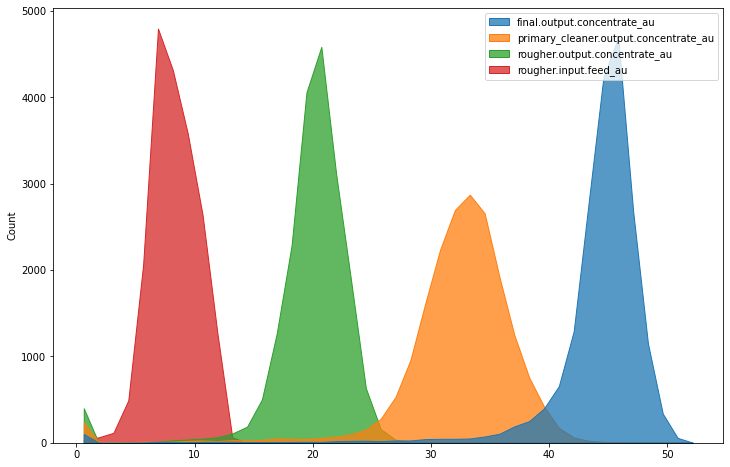

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(au_concentrate, element='poly')

<AxesSubplot:ylabel='Count'>

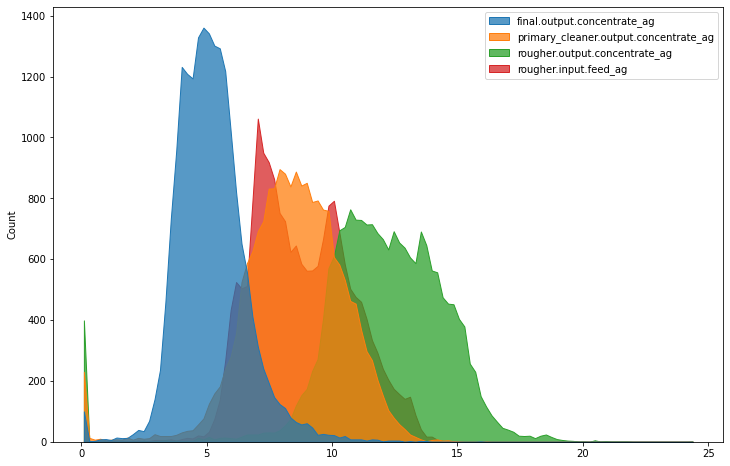

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(ag_concentrate, element='poly')

<AxesSubplot:ylabel='Count'>

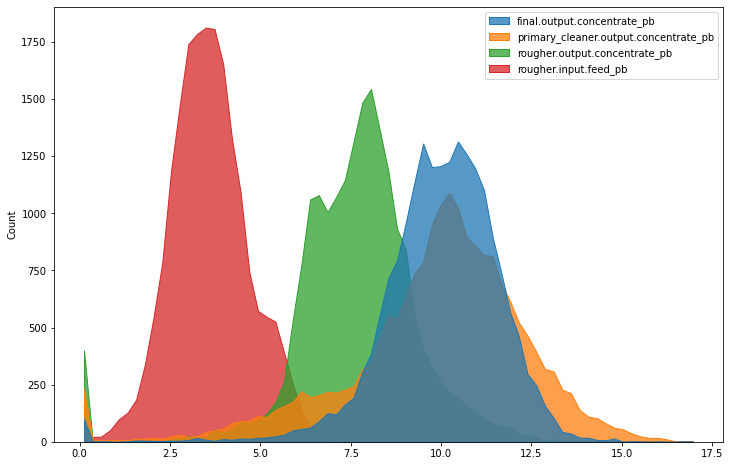

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(pb_concentrate, element='poly')

Распределения концентрации каждого металла после очистки являются нормальными, но стоит отметить несколько особенностей. Сильное повышение концентрата с каждым этапом очистки наблюдается у золота, у серебра концентрация наоборот уменьшается к финальному варианту, а повышается только при переходе от сырья к концентрату после флотации. У свинца показатель концентрации повышается после этапов, но не так резко, т.е у свинца показатель концентрации после первой очистки почти не отличается от концентрации в финальном виде.

### Распределения размеров гранул сырья

Сравню распределения размеров гранул сырья на обучающей и тестовой выборках. В датафреймах они обозначаются как feed size.

In [ ]:
feed_size_test = data_test[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]
feed_size_train = data_train[['rougher.input.feed_size', 'primary_cleaner.input.feed_size']]

<AxesSubplot:ylabel='Density'>

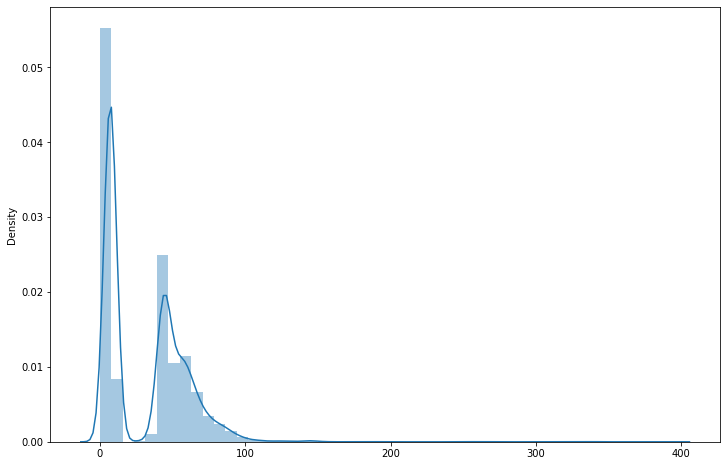

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(feed_size_test)

<AxesSubplot:ylabel='Density'>

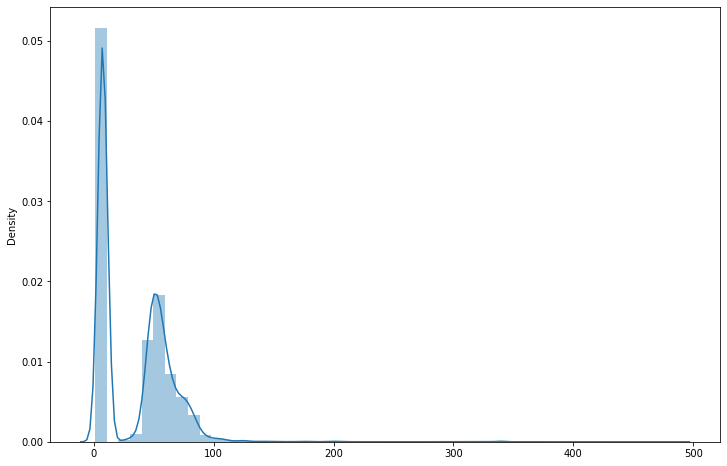

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(feed_size_train)

Можем отметить, что в размерах гранул сырья есть большие выбросы в обоих датасетах, также отметим что после флотации размер гранул сильно уменьшается. Тем не менее распределения двух датасетов похожи: резкий пик в области 0-10 у сырья до первой очистки и нормальное распределение размера гранул вокруг 50 до флотации. Также стоит отметить, что распределение сырья до флотации смещено вправо.

### Сумарная концентрация веществ

Исследую суммарную концентрацию всех веществ на стадиях сырья(rougher.input), в черновом(rougher.output) и финальном концентратах (final.output). Проверю по гистограммам на наличие выбросов в данных.

In [ ]:
concentrate_all_feed = data_full[['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_au']].sum(axis=1)
concentrate_all_rougher = data_full[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']].sum(axis=1)
concentrate_all_final = data_full[['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']].sum(axis=1)

<AxesSubplot:ylabel='Count'>

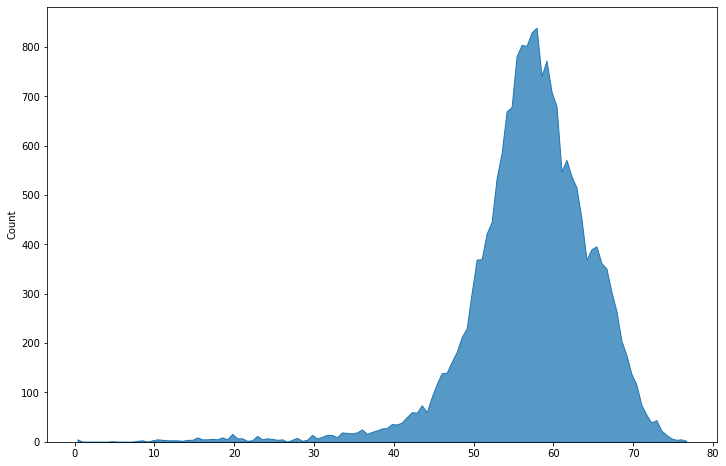

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(concentrate_all_feed, element='poly')

<AxesSubplot:ylabel='Count'>

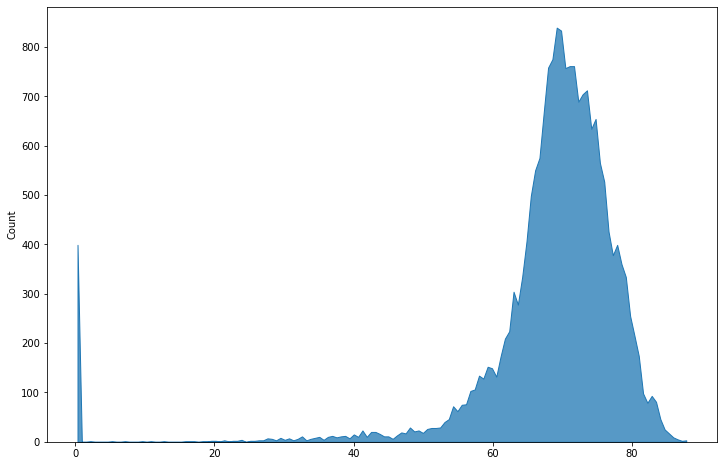

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(concentrate_all_rougher, element='poly')

<AxesSubplot:ylabel='Count'>

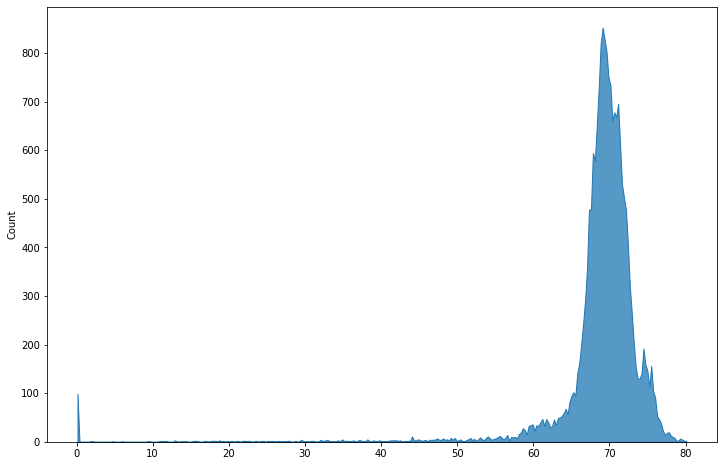

In [ ]:
plt.figure(figsize=(12,8))
sns.histplot(concentrate_all_final, element='poly')

На этапе после флотации есть пик в районе нулевого значения концентрации, также есть некоторое количество околонулевых значений в гистограмме финальной концентрации веществ. Удалю выбросы, т.е. удалю значения концентрации меньше 2 единиц. Применю удаление аномалий для полной выборки.

In [ ]:
#data_full = data_full.query('`rougher.input.feed_ag` > 1')
#data_full = data_full.query('`rougher.input.feed_pb` > 1')
#data_full = data_full.query('`rougher.input.feed_sol` > 1')
#data_full = data_full.query('`rougher.input.feed_au` > 1')
#data_full = data_full.query('`rougher.output.concentrate_ag` > 1')
#data_full = data_full.query('`rougher.output.concentrate_pb` > 1')
#data_full = data_full.query('`rougher.output.concentrate_sol` > 1')
#data_full = data_full.query('`rougher.output.concentrate_au` > 1')
#data_full = data_full.query('`final.output.concentrate_ag` > 1')
#data_full = data_full.query('`final.output.concentrate_pb` > 1')
#data_full = data_full.query('`final.output.concentrate_sol` > 1')
#data_full = data_full.query('`final.output.concentrate_au` > 1')

In [ ]:
sub = [concentrate_all_feed, concentrate_all_rougher, concentrate_all_final]
for i in sub:
    data_full = data_full.query('@i > 1')

Я удалил выбросы из data_full, но для дальнейшего обучения модели нас интересует data_train. Найду аномальные строки в data_train путем присвоение датафрейму data_full индексов по столбцу date, как это было сделано ранее для data_train. Затем удалю аномалии из data_train.

In [ ]:
data_full = data_full.set_index('date')
data_train = data_train[data_train.index.isin(data_full.index)]

## Построение модели

### Функция sMAPE

Прежде,чем построить модель построю функцию для расчета метрики качества sMAPE (Symmetric Mean Absolute Percentage Error) для оценки модели предсказания коэффициента восстановления золота из золотосодержащей руды 

In [ ]:
def smape (target, prediction):
    error = np.abs(target - prediction)
    scale = (np.abs(target) + np.abs(prediction)) / 2
    return (error / scale).mean() * 100

In [ ]:
def final_smape(smape_rougher, smape_final):
    return .25 * smape_rougher + .75 * smape_final

Сначала функция  дает оценку по одному виду предсказания, но у нас два целевых признака, поэтому в функции final_smape мы выводим окончательную оценку, отражающую эффективность обогащения как чернового концентрата (rougher), так и финального (final)

Для того, чтобы при проведении в дальнейшем кросс-валидации моделей использовать не дефолтную оценку, а оценку функцией, которую мы создали и  используем для нашей конкретной задачи (sMAPE), создам такую кастомную метрику с помощью make_scorer, для параметра greater_is_better установлю False, мы ищем модель, при которой ошибка будет меньше.

In [ ]:
smape_score = make_scorer(smape, greater_is_better=False)

### Выбор лучшей модели регрессии

Перед началом обучения проведу деление выборок на признаки. Учитываю, что у меня два целевых признака: rougher.output.recovery, final.output.recovery.

In [ ]:
targets = ['rougher.output.recovery', 'final.output.recovery']
features = data_test.columns.values

In [ ]:
target_train = data_train[targets].reset_index(drop=True)
features_train = data_train[features].reset_index(drop=True)

In [ ]:
features_train = features_train.drop(['rougher.output.recovery'],axis = 1)
features_train = features_train.drop(['final.output.recovery'],axis = 1)

In [ ]:
target_test = data_test[targets].reset_index(drop=True)
features_test = data_test.drop(['rougher.output.recovery'], axis=1)
features_test = features_test.drop(['final.output.recovery'], axis=1)

In [ ]:
target_train_rougher = target_train['rougher.output.recovery']
target_train_final = target_train['final.output.recovery']

In [ ]:
target_test_rougher = target_test['rougher.output.recovery']
target_test_final = target_test['final.output.recovery']

Теперь с помощью GridSearchCV построю несколько моделей (регрессия решающего дерева (DecisionTreeRegressor), регрессия случайного леса (RandomForestRegressor) и линейная регрессия (LinearRegression)), проделаю несколько шагов:

    1.Введу диапазон гиперпараметров для моделей
    2.Зафиксирую random_state
    3.Передам GridSearchCV модель для нахождения оптимальных гиперпараметров
    4.Проведу кросс-валидацию на трех блоках и передам в нее сразу функцию smape в качестве метрики
    5.Вычислю с помощью функции final_smape итоговый показатель метрики каждой модели
    6.Сравню метрику с константной моделью

#### DecisionTreeRegressor

In [ ]:
param_1 = {'min_samples_split': range(2, 6, 2), 'max_depth': range(2, 6, 2), 'min_samples_leaf': range(1, 4, 1)}
state = np.random.RandomState(123)

In [ ]:
grid = GridSearchCV(DecisionTreeRegressor(random_state=state), param_1, scoring=smape_score, cv=5, n_jobs=-1)
grid.fit(features_train, target_train_rougher)
print('Лучшие параметры Регрессия решающего дерева для rougher', grid.best_params_)

Лучшие параметры Регрессия решающего дерева для rougher {'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [ ]:
dtr_rougher_score = -grid.best_score_
print('Оценка Регрессии решающего дерева для rougher', dtr_rougher_score)

Оценка Регрессии решающего дерева для rougher 7.430287586127744


Сделали для целевого признака rougher.output.recovery, теперь для final.output.recovery:

In [ ]:
grid = GridSearchCV(DecisionTreeRegressor(random_state=state), param_1, scoring=smape_score, cv=5, n_jobs=-1)
grid.fit(features_train, target_train_final)
print('Лучшие параметры Регрессия решающего дерева для final', grid.best_params_)

Лучшие параметры Регрессия решающего дерева для final {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
dtr_final_score = -grid.best_score_
print('Оценка Регрессии решающего дерева для final', dtr_final_score)

Оценка Регрессии решающего дерева для final 9.3611043426731


In [ ]:
dtr_final_smape = final_smape(dtr_rougher_score, dtr_final_score)
print('Финальная sMAPE для для модели Регрессии решающего дерева =', dtr_final_smape)

Финальная sMAPE для для модели Регрессии решающего дерева = 8.878400153536761


#### RandomForestRegressor

In [ ]:
param_2 = {'n_estimators' : range(100, 131, 10), 'min_samples_split': range(2, 4, 2), 'max_depth': range(2, 4, 2), 'min_samples_leaf': range(2, 4, 2)}

In [ ]:
grid = GridSearchCV(RandomForestRegressor(random_state=state), param_2, scoring=smape_score, cv=5, n_jobs=-1)
grid.fit(features_train, target_train_rougher)
print('Лучшие параметры Регрессия случайного леса для rougher', grid.best_params_)

Лучшие параметры Регрессия случайного леса для rougher {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rfr_rougher_score = -grid.best_score_
print('Оценка Регрессии случайного леса для rougher', rfr_rougher_score)

Оценка Регрессии случайного леса для rougher 7.165162211469837


In [ ]:
grid = GridSearchCV(RandomForestRegressor(random_state=state), param_2, scoring=smape_score, cv=5, n_jobs=-1)
grid.fit(features_train, target_train_final)
print('Лучшие параметры Регрессия случайного леса для final', grid.best_params_)

Лучшие параметры Регрессия случайного леса для final {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
rfr_final_score = -grid.best_score_
print('Оценка Регрессии случайного леса для final', rfr_final_score)

Оценка Регрессии случайного леса для final 9.190096899093959


In [ ]:
rfr_final_smape = final_smape(rfr_rougher_score, rfr_final_score)
print('Финальная sMAPE для для модели Регрессии случайного леса =', rfr_final_smape)

Финальная sMAPE для для модели Регрессии случайного леса = 8.683863227187928


#### LinearRegression

In [ ]:
param_3 = {'fit_intercept' : range(0,1)}

In [ ]:
grid = GridSearchCV(LinearRegression(), param_3, scoring=smape_score, n_jobs = -1, cv=5)
grid.fit(features_train, target_train_rougher)
print('Лучшие параметры Линейная регрессия для rougher', grid.best_params_)

Лучшие параметры Линейная регрессия для rougher {'fit_intercept': 0}


In [ ]:
lr_rougher_score = -grid.best_score_
print('Оценка Линейная регрессия для rougher', lr_rougher_score)

Оценка Линейная регрессия для rougher 7.688828092832717


In [ ]:
grid = GridSearchCV(LinearRegression(), param_3, scoring=smape_score, n_jobs = -1, cv=5,)
grid.fit(features_train, target_train_final)
print('Лучшие параметры Линейная регрессия для final', grid.best_params_)

Лучшие параметры Линейная регрессия для final {'fit_intercept': 0}


In [ ]:
lr_final_score = -grid.best_score_
print('Оценка Линейная регрессия для final', lr_final_score)

Оценка Линейная регрессия для final 10.890871995381579


In [ ]:
lr_final_smape = final_smape(lr_rougher_score, lr_final_score)
print('Финальная sMAPE для для модели Регрессии случайного леса =', lr_final_smape)

Финальная sMAPE для для модели Регрессии случайного леса = 10.090361019744362


Я построил три модели, подобрал гиперпараметры, лучший показатель метрики sMAPE оказался у модели Регрессии случайного леса, при этом оптимальные гиперпараметры этой модели для двух таргетных признаков оказались разными. Буду использовать эту модель на тестовой выборке

#### Сравнение с константной моделью

Для того, чтобы понять, адекватна ли модель, сравню sMAPE моделей с sMAPE константной модели, в ней будет предсказанием медиана по таргетному признаку.

In [ ]:
predict_constant_rougher = pd.Series(target_train_rougher.median(), index=target_train_rougher.index)
predict_constant_final = pd.Series(target_train_final.median(), index=target_train_final.index)

In [ ]:
smape_constant_rougher = smape(target_train_rougher, predict_constant_rougher)
smape_constant_final = smape(target_train_final, predict_constant_final)
smape_constant_rougher = final_smape(smape_constant_rougher, smape_constant_final)
print('Финальное sMAPE константной модели =', smape_constant_rougher)

Финальное sMAPE константной модели = 9.448962714511023


Константная модель оказалась по final_smape лучше, чем линейная регрессия, но отстала от регрессий решающего дерева и случайного леса. Лучший показатель остается у регрессии случайного леса.

#### Дополнительно: модель с двумя таргетам

In [ ]:
def smape(y_true, y_pred):
    error = abs(y_true - y_pred)
    scale = (abs(y_true) + abs(y_pred)) / 2 + 0.000000001
    result = (error / scale).mean()
    return result

In [ ]:
def smape_weighted(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = pd.DataFrame(y_true.values)
    else:
        y_true = pd.DataFrame(y_true)
    if isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred.values)
    else:
        y_pred = pd.DataFrame(y_pred)
    rougher = smape(y_true.iloc[:, 0], y_pred.iloc[:, 0])
    final = smape(y_true.iloc[:, 1], y_pred.iloc[:, 1])
    return 0.25 * rougher + 0.75 * final

In [ ]:
smape_weighted_score = make_scorer(smape_weighted, greater_is_better=False)

In [ ]:
grid = GridSearchCV(DecisionTreeRegressor(), param_1, scoring=smape_weighted_score, cv=5, n_jobs=-1)
grid.fit(features_train, target_train)
print('Лучшие параметры Регрессия решающего дерева для rougher', grid.best_params_)

Лучшие параметры Регрессия решающего дерева для rougher {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [ ]:
-grid.best_score_

0.09190696189176903

## Проверка на тестовой выборке

Лучшей моделью по итоговому sMAPE оказалась регрессия случайного леса, применю найденные оптимальные гиперпараметры и оценю модель на тестовой выборке.

In [ ]:
model_rougher = RandomForestRegressor(n_estimators=130, max_depth=2, min_samples_leaf=2, min_samples_split=2)
model_rougher.fit(features_train, target_train_rougher)
test_rougher_predict = model_rougher.predict(features_test)
test_rougher_score = smape(target_test_rougher, test_rougher_predict)

In [ ]:
model_final = RandomForestRegressor(n_estimators=110, max_depth=2, min_samples_leaf=2, min_samples_split=2)
model_final.fit(features_train, target_train_final)
test_final_predict = model_final.predict(features_test)
test_final_score = smape(target_test_final, test_final_predict)

In [ ]:
final_smape_test = final_smape(test_rougher_score, test_final_score)
print('Итоговое sMAPE на тестовой выборке =', final_smape_test)

Итоговое sMAPE на тестовой выборке = 9.068684488307644


Метрика итогового sMAPE на тестовой выборке получилось хуже, чем при нахождении оценки на этапе обучения, но в пределах адекватных значений. Лучшая модель - Регрессия случайного леса с подобранными гиперпараметрами.

## Выводы

Я провел предобработку и исследовательский анализ данных из золотодобывающей отрасли. Поставленные в начале исследования были выполнены, и после подготовки данных были найдена оптимальная модель предсказания коэффициента восстановления золота из золотосодержащей руды. Для данной модели Регрессии случайного леса были подобранны гиперпараметры на основе метрики sMAPE. Проверка на адекватность методом сравнения с константной моделью и последующая проверка непосредственно на тестовой выборке позволяет предположить, что построенная модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.